In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
from datetime import datetime,timedelta
import datetime as dt
from sklearn.metrics import classification_report


In [2]:
# DATA Collection

urls = ['https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2010.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2011.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2012.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2013.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2014.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2015.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2016.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2016.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2017.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2018.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2019.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2020.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2021.csv']

dfs = [pd.read_csv(url,sep=';') for url in urls]
data = pd.concat(dfs, ignore_index=True)

# Keep colums we need -> Only keep data known at game time 

data.drop(['WPts','LPts','W1','L1','W2','L2','W3','L3','W4','L4','W5','L5','Wsets','Lsets','EXW','EXL','LBW','LBL','SJW','SJL','MaxW','MaxL','AvgW','AvgL'],axis=1,inplace=True)

#Format adjustment

data.PSW= (data.PSW.replace(',','.', regex=True).astype(float))
data.PSL= (data.PSL.replace(',','.', regex=True).astype(float))
data.B365W= (data.B365W.replace(',','.', regex=True).astype(float))
data.B365L= (data.B365L.replace(',','.', regex=True).astype(float)) 

data['Date'] = pd.to_datetime(data.Date,dayfirst=True)

data.sort_values(['Date'], inplace=True)
data=data.reset_index(drop=True)


# **CODE PROPRE**

In [3]:
data.head(3)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Comment,B365W,B365L,PSW,PSL
0,1,Brisbane,Brisbane International,2010-01-04,ATP250,Outdoor,Hard,1st Round,3,Gasquet R.,Nieminen J.,52.0,88.0,Completed,1.44,2.62,1.526,2.740
1,2,Chennai,Chennai Open,2010-01-04,ATP250,Outdoor,Hard,1st Round,3,Tipsarevic J.,Moya C.,38.0,446.0,Completed,1.40,2.75,1.433,3.110
2,2,Chennai,Chennai Open,2010-01-04,ATP250,Outdoor,Hard,1st Round,3,Giraldo S.,Phau B.,107.0,111.0,Completed,2.00,1.72,2.140,1.813


## **Data Pre-processing**

#### Timeframe selection

In [4]:
# Given there are some duplicated lines in 2012 and data stop between 2013-11-11 to 2014-01-05, we'll start the analysis from 2015.

# Data selection

beg=datetime(2015,1,1) 
end=datetime(2021,12,31)

indices=data[(data.Date>beg)&(data.Date<=end)].index
data=data.iloc[indices,:]

print("Number of games since Jan'2015: ",len(data))

data.sort_values(['Date'], inplace=True)
data=data.reset_index(drop=True)


Number of games since Jan'2015:  18783


#### ELO Ranking Computing

In [5]:
def compute_elo_rankings(data):
    """
    Given the list of matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    """
    print("Elo rankings computing...")
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index) # Gather all players from data
    elo=pd.Series(np.ones(len(players))*1500,index=players) # Attribute Elo Ranking of 1500 to each player
    ranking_elo=[(1500,1500)]
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner   # Select Winner and Loser of the previous game
        l=data.iloc[i-1,:].Loser
        elow=elo[w]  
        elol=elo[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))  # Win prob resulting from elo. Ex: elol = 1900, elow = 2000. Delta = 100 -> winner prob = 64%
        K_win=32
        K_los=32
        new_elow=elow+K_win*(1-pwin) # The winner has his elo increased by K_win*(1-pwin). Ex: 1500 + 32*(1-0.64) = 1511.52. 
        new_elol=elol-K_los*(1-pwin) # A victory against a better ranked player grants more points.
        elo[w]=new_elow
        elo[l]=new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%3000==0:
            print(str(i)+" matches computed...")
    ranking_elo=pd.DataFrame(ranking_elo,columns=["elo_winner","elo_loser"]) 
    ranking_elo["p_elo_winner"]=1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    ranking_elo["p_elo_loser"]=1 / (1 + 10 ** ((ranking_elo["elo_winner"] - ranking_elo["elo_loser"]) / 400))
    return ranking_elo

# Computing of the elo ranking of each player at the beginning of each match.
elo_rankings = compute_elo_rankings(data)
data = pd.concat([data,elo_rankings],1)


Elo rankings computing...
3000 matches computed...
6000 matches computed...
9000 matches computed...
12000 matches computed...
15000 matches computed...
18000 matches computed...


In [6]:
# Check elo ranking computing

data[(data.Winner=='Federer R.')|(data.Loser=='Federer R.')].head(7)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Comment,B365W,B365L,PSW,PSL,elo_winner,elo_loser,p_elo_winner,p_elo_loser
61,1,Brisbane,Brisbane International,2015-01-08,ATP250,Outdoor,Hard,2nd Round,3,Federer R.,Millman J.,2.0,153.0,Completed,1.06,10.00,1.07,10.25,1500.000000,1516.000000,0.476990,0.523010
72,1,Brisbane,Brisbane International,2015-01-09,ATP250,Outdoor,Hard,Quarterfinals,3,Federer R.,Duckworth J.,2.0,125.0,Completed,1.05,11.00,1.06,13.40,1516.736307,1532.000000,0.478048,0.521952
81,1,Brisbane,Brisbane International,2015-01-10,ATP250,Outdoor,Hard,Semifinals,3,Federer R.,Dimitrov G.,2.0,11.0,Completed,1.28,3.75,1.32,3.79,1533.438774,1533.438774,0.500000,0.500000
83,1,Brisbane,Brisbane International,2015-01-11,ATP250,Outdoor,Hard,The Final,3,Federer R.,Raonic M.,2.0,8.0,Completed,1.25,4.00,1.30,3.97,1549.438774,1549.438774,0.500000,0.500000
165,6,Melbourne,Australian Open,2015-01-19,Grand Slam,Outdoor,Hard,1st Round,5,Federer R.,Lu Y.H.,2.0,47.0,Completed,1.02,17.00,1.03,20.00,1565.438774,1513.188319,0.574633,0.425367
218,6,Melbourne,Australian Open,2015-01-21,Grand Slam,Outdoor,Hard,2nd Round,5,Federer R.,Bolelli S.,2.0,48.0,Completed,1.02,17.00,1.03,18.00,1579.050529,1529.287716,0.571129,0.428871
237,6,Melbourne,Australian Open,2015-01-23,Grand Slam,Outdoor,Hard,3rd Round,5,Seppi A.,Federer R.,46.0,2.0,Completed,17.00,1.02,23.50,1.02,1543.793749,1592.774410,0.429974,0.570026


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18783 entries, 0 to 18782
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ATP           18783 non-null  int64         
 1   Location      18783 non-null  object        
 2   Tournament    18783 non-null  object        
 3   Date          18783 non-null  datetime64[ns]
 4   Series        18783 non-null  object        
 5   Court         18783 non-null  object        
 6   Surface       18783 non-null  object        
 7   Round         18783 non-null  object        
 8   Best of       18783 non-null  int64         
 9   Winner        18783 non-null  object        
 10  Loser         18783 non-null  object        
 11  WRank         18773 non-null  float64       
 12  LRank         18732 non-null  float64       
 13  Comment       18783 non-null  object        
 14  B365W         18727 non-null  float64       
 15  B365L         18728 non-null  float6

#### Remove outliers and absurd values

In [8]:
# Only use normal completed games

data = data[data.Comment == 'Completed']
data.drop('Comment',axis=1,inplace=True)

# Remove Round Robin tournaments as they interfere with some cumulative stats calculations

data = data[data.Round != 'Round Robin']

# Odds need to be > 1

data = data[(data.PSW >1)&(data.PSL>1)&(data.B365W>1)&(data.B365W>1)]

# ATP rankings cannot be 0

data = data[(data.WRank != 0) & (data.LRank != 0)]

# Remove remaining NaNs

data.dropna(axis=0,inplace=True)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17892 entries, 0 to 18782
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ATP           17892 non-null  int64         
 1   Location      17892 non-null  object        
 2   Tournament    17892 non-null  object        
 3   Date          17892 non-null  datetime64[ns]
 4   Series        17892 non-null  object        
 5   Court         17892 non-null  object        
 6   Surface       17892 non-null  object        
 7   Round         17892 non-null  object        
 8   Best of       17892 non-null  int64         
 9   Winner        17892 non-null  object        
 10  Loser         17892 non-null  object        
 11  WRank         17892 non-null  float64       
 12  LRank         17892 non-null  float64       
 13  B365W         17892 non-null  float64       
 14  B365L         17892 non-null  float64       
 15  PSW           17892 non-null  float6

#### Create cumulative stats 



In [10]:
# Player dataset preparation

# Step 1 -> Copy Data and add a counter for victorie and defeats

data.reset_index(inplace=True)

df1 = data.copy()
df1['w']=1
df1['l']=0

# step 2 -> Select and concatenate the columns we need

index=df1['index']
winner=df1['Winner']
loser=df1['Loser']
surface=df1['Surface']
w=df1['w']
l=df1['l']
date=df1['Date']

df2 = pd.concat([index,winner,loser,surface,w,l,date], axis = 1)

df2.head()

,index,Winner,Loser,Surface,w,l,Date
0,0,Muller G.,Roger-Vasselin E.,Hard,1,0,2015-01-05
1,1,Chardy J.,Golubev A.,Hard,1,0,2015-01-05
2,2,Tomic B.,Querrey S.,Hard,1,0,2015-01-05
3,3,Duckworth J.,Simon G.,Hard,1,0,2015-01-05
4,4,Coric B.,Haase R.,Hard,1,0,2015-01-05


In [11]:
# step 3 -> Create Player dataframe : create a row for each player (double nb of lines)

player=pd.concat([winner,loser], axis = 0)
status=pd.concat([w,l], axis = 0)
index=pd.concat([index,index], axis = 0)
surface=pd.concat([surface,surface], axis = 0)
date=pd.concat([date,date], axis = 0)

df3 = pd.concat([index,player, status,surface,date], axis = 1)
df3.columns = ['index','Player','Winner','Surface','Date']


In [12]:
df3.head()


,index,Player,Winner,Surface,Date
0,0,Muller G.,1,Hard,2015-01-05
1,1,Chardy J.,1,Hard,2015-01-05
2,2,Tomic B.,1,Hard,2015-01-05
3,3,Duckworth J.,1,Hard,2015-01-05
4,4,Coric B.,1,Hard,2015-01-05


In [13]:
# Create 'Shape' indicator based on recent number of games played 

#def forme (row):
  # if ((row['Played_R'] >= 4)):
     # return 1
   #elif ((row['Played_R'] >=3) & (row['Played_R'] < 4) & (row['Win_rate_R'] >= 0.5)):
    #  return 2
  # elif ((row['Played_R'] >=2) & (row['Played_R'] < 3) & (row['Win_rate_R'] > 0.5)):
    #  return 3
   #elif ((row['Played_R'] >=1) & (row['Played_R'] < 2) & (row['Win_rate_R'] > 0.5)):
    #  return 4
   #else:
    #  return 5
    
#data_players['Shape'] = data_players.apply (lambda row: forme(row), axis=1)

In [14]:
df3.info()
print(df3.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35784 entries, 0 to 17891
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   index    35784 non-null  int64         
 1   Player   35784 non-null  object        
 2   Winner   35784 non-null  int64         
 3   Surface  35784 non-null  object        
 4   Date     35784 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.6+ MB
0


In [15]:
# Collect and merge new data on players (Birthday + Strong hand) -> Idea not kept

#url2 = 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/Player.csv'
#player = pd.read_csv(url2)

# Format players name so that they can be merged with data_players

#player['Player'] = player['name'].str.split().str[1:].str.join(" ").add(" "+player['name'].str[0].str[0].add("."))
#player.drop(['player_id','country','name'],axis=1,inplace=True)

# Remove duplicated players and players with no birthday

#player.drop_duplicates(subset='Player',keep='first',inplace=True)
#player.dropna(axis=0,inplace=True)
#player.Player.duplicated().sum()

# Conversion to DateTime

#player['birthday'] = pd.to_datetime(player.birthday)

# Merging Birthday + Strong hand data

#data_players=data_players.merge(right=player,on = "Player",how = "left")

# Replace NaN in 'Strong Hand' with 'U' for 'unidentified

#data_players.hand.fillna('U',inplace=True)

In [16]:
# step 4 -> Pivot table 

df_players = pd.pivot_table(df3,index=['Player','index','Surface','Date'])
df_players.head()

Winner
Player    index Surface Date              
Ahouda A. 4248  Clay    2016-04-05       0
          4259  Clay    2016-04-05       0
          8690  Clay    2017-04-11       1
          8716  Clay    2017-04-13       0
          11335 Clay    2018-04-10       0

In [17]:
# step 5 -> Build Defeats counter where winner = 0.

df_players['Loser']=df_players['Winner'].apply(lambda x: 0 if x ==1 else 1)

In [18]:
df_players.head()

Winner  Loser
Player    index Surface Date                     
Ahouda A. 4248  Clay    2016-04-05       0      1
          4259  Clay    2016-04-05       0      1
          8690  Clay    2017-04-11       1      0
          8716  Clay    2017-04-13       0      1
          11335 Clay    2018-04-10       0      1

In [19]:
# step 6 -> Sort Players Dataframe by Date (preparation for cumulative variables)

df_players.reset_index(inplace=True)
df_players.set_index(['Date'], inplace=True)
df_players.sort_values(['Date'], inplace=True)

In [20]:
df_players.head()

,Player,index,Surface,Winner,Loser
Date,,,,,
2015-01-05,Duckworth J.,3,Hard,1,0
2015-01-05,Kokkinakis T.,6,Hard,1,0
2015-01-05,Becker B.,11,Hard,0,1
2015-01-05,Karlovic I.,12,Hard,1,0
2015-01-05,Coric B.,4,Hard,1,0


In [21]:
# Step 7 : Build cumlative stats

df_surface = df_players.copy()

# step 7a -> Cumulative wins/defeats (Rolling sum on recent days removing game of the day because result still unknown)

df_players['Wins_R']=df_players.groupby('Player')['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Winner']  # NB days can be changed if needed
df_players['Defeats_R']=df_players.groupby('Player')['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Loser'] # NB days can be changed if needed
df_players['Played_R']=df_players['Wins_R']+df_players['Defeats_R']
df_players['WinRate_R']=df_players['Wins_R']/df_players['Played_R']
df_players['WinRate_R'].fillna(0,inplace=True)

In [22]:
# check

df_players[(df_players.Player=='Federer R.')|(df_players.Player=='Federer R.')].head(7)

,Player,index,Surface,Winner,Loser,Wins_R,Defeats_R,Played_R,WinRate_R
Date,,,,,,,,,
2015-01-08,Federer R.,61,Hard,1,0,0,0,0,0.0
2015-01-09,Federer R.,72,Hard,1,0,1,0,1,1.0
2015-01-10,Federer R.,81,Hard,1,0,2,0,2,1.0
2015-01-11,Federer R.,83,Hard,1,0,3,0,3,1.0
2015-01-19,Federer R.,165,Hard,1,0,4,0,4,1.0
2015-01-21,Federer R.,218,Hard,1,0,5,0,5,1.0
2015-01-23,Federer R.,237,Hard,0,1,6,0,6,1.0


In [23]:
# # step 7b -> Cumulative wins/defeats by surface

df_surface.Surface.value_counts()

Hard     20032
Clay     11466
Grass     4286
Name: Surface, dtype: int64

In [24]:
df_surface['Wins_R']=df_surface.groupby(['Player','Surface'])['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Winner']  # NB days can be changed if needed
df_surface['Defeats_R']=df_surface.groupby(['Player','Surface'])['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Loser'] # NB days can be changed if needed
df_surface['Played_R']=df_surface['Wins_R']+df_surface['Defeats_R']
df_surface['WinRate_R']=df_surface['Wins_R']/df_surface['Played_R']
df_surface['WinRate_R'].fillna(0,inplace=True)

In [25]:
# check

df_surface[(df_players.Player=='Federer R.')|(df_players.Player=='Federer R.')].head()

,Player,index,Surface,Winner,Loser,Wins_R,Defeats_R,Played_R,WinRate_R
Date,,,,,,,,,
2015-01-08,Federer R.,61,Hard,1,0,0,0,0,0.0
2015-01-09,Federer R.,72,Hard,1,0,1,0,1,1.0
2015-01-10,Federer R.,81,Hard,1,0,2,0,2,1.0
2015-01-11,Federer R.,83,Hard,1,0,3,0,3,1.0
2015-01-19,Federer R.,165,Hard,1,0,4,0,4,1.0


In [26]:
# step 8 Prepare'df_players' and 'df_surface' for merge with Data

# A. Sort Dataframe (same as Data)

df_players.sort_values(['index','Loser'], inplace=True)
df_surface.sort_values(['index','Loser'], inplace=True)

# B. Take every other line of df_Players/df_Surface to reduce the dataframe by half // Data

Players_merge = pd.DataFrame({'Winner':df_players['Player'].iloc[::2].values, 'Loser':df_players['Player'].iloc[1::2].values,
                        'Winner_wins_R':df_players['Wins_R'].iloc[::2].values, 'Loser_wins_R':df_players['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_R':df_players['Defeats_R'].iloc[::2].values, 'Loser_defeats_R':df_players['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_R':df_players['Played_R'].iloc[::2].values, 'Loser_Played_R':df_players['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_R':df_players['WinRate_R'].iloc[::2].values, 'Loser_WinRate_R':df_players['WinRate_R'].iloc[1::2].values,
                        'Winner_wins_S':df_surface['Wins_R'].iloc[::2].values, 'Loser_wins_S':df_surface['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_S':df_surface['Defeats_R'].iloc[::2].values, 'Loser_defeats_S':df_surface['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_S':df_surface['Played_R'].iloc[::2].values, 'Loser_Played_S':df_surface['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_S':df_surface['WinRate_R'].iloc[::2].values, 'Loser_WinRate_S':df_surface['WinRate_R'].iloc[1::2].values,
                        'index':df_players['index'].iloc[1::2].values})

In [27]:
Players_merge.head()

,Winner,Loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S,index
0,Muller G.,Roger-Vasselin E.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0
1,Chardy J.,Golubev A.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,1
2,Tomic B.,Querrey S.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
3,Duckworth J.,Simon G.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,3
4,Coric B.,Haase R.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,4


In [28]:
#Check

Players_merge[(Players_merge.Winner=='Federer R.')|(Players_merge.Loser=='Federer R.')].head()

,Winner,Loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S,index
59,Federer R.,Millman J.,0,1,0,0,0,1,0.0,1.0,0,1,0,0,0,1,0.0,1.0,61
70,Federer R.,Duckworth J.,1,2,0,0,1,2,1.0,1.0,1,2,0,0,1,2,1.0,1.0,72
79,Federer R.,Dimitrov G.,2,2,0,0,2,2,1.0,1.0,2,2,0,0,2,2,1.0,1.0,81
81,Federer R.,Raonic M.,3,3,0,0,3,3,1.0,1.0,3,3,0,0,3,3,1.0,1.0,83
161,Federer R.,Lu Y.H.,4,3,0,2,4,5,1.0,0.6,4,3,0,2,4,5,1.0,0.6,165


In [29]:
# step 9 -> Merging Data with Players on: index, Loser, Winner 

Players_merge.rename(columns={'index': 'index_t', 'Winner': 'Winner_t', 'Loser': 'Loser_t'},inplace=True)
data=pd.concat([data,Players_merge], axis = 1)
data.drop(['index_t','Winner_t','Loser_t'],axis=1,inplace=True)

In [30]:
#Check

data[(data.Winner=='Federer R.')|(data.Loser=='Federer R.')].head()

,index,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,B365W,B365L,PSW,PSL,elo_winner,elo_loser,p_elo_winner,p_elo_loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S
59,61,1,Brisbane,Brisbane International,2015-01-08,ATP250,Outdoor,Hard,2nd Round,3,Federer R.,Millman J.,2.0,153.0,1.06,10.00,1.07,10.25,1500.000000,1516.000000,0.476990,0.523010,0,1,0,0,0,1,0.0,1.0,0,1,0,0,0,1,0.0,1.0
70,72,1,Brisbane,Brisbane International,2015-01-09,ATP250,Outdoor,Hard,Quarterfinals,3,Federer R.,Duckworth J.,2.0,125.0,1.05,11.00,1.06,13.40,1516.736307,1532.000000,0.478048,0.521952,1,2,0,0,1,2,1.0,1.0,1,2,0,0,1,2,1.0,1.0
79,81,1,Brisbane,Brisbane International,2015-01-10,ATP250,Outdoor,Hard,Semifinals,3,Federer R.,Dimitrov G.,2.0,11.0,1.28,3.75,1.32,3.79,1533.438774,1533.438774,0.500000,0.500000,2,2,0,0,2,2,1.0,1.0,2,2,0,0,2,2,1.0,1.0
81,83,1,Brisbane,Brisbane International,2015-01-11,ATP250,Outdoor,Hard,The Final,3,Federer R.,Raonic M.,2.0,8.0,1.25,4.00,1.30,3.97,1549.438774,1549.438774,0.500000,0.500000,3,3,0,0,3,3,1.0,1.0,3,3,0,0,3,3,1.0,1.0
161,165,6,Melbourne,Australian Open,2015-01-19,Grand Slam,Outdoor,Hard,1st Round,5,Federer R.,Lu Y.H.,2.0,47.0,1.02,17.00,1.03,20.00,1565.438774,1513.188319,0.574633,0.425367,4,3,0,2,4,5,1.0,0.6,4,3,0,2,4,5,1.0,0.6


#### Remove Winners / Losers -> Replace with P1 and P2 taken randomly 

In [31]:
# Values of Player 1 and 2 are taken randomly

# First we create Player 1

v = data[['Winner', 'Loser']].values
ix = np.random.randint(0,v.shape[1],data.shape[0])
data['P1'] = np.take_along_axis(v, ix[:,None], 1)

# Then Player 2 

data['P2'] = np.where(data.P1 == data.Winner,data.Loser, data.Winner)

# We then allocate all the attributes by checking the position of P1/P2 vs Winner/Loser on each line:

data['P1_Rank']=np.where(data.P1 == data.Winner,data.WRank,data.LRank)
data['P2_Rank']=np.where(data.P2 == data.Winner,data.WRank,data.LRank)

data['P1_Elo']=np.where(data.P1 == data.Winner,data.elo_winner,data.elo_loser)
data['P2_Elo']=np.where(data.P2 == data.Winner,data.elo_winner,data.elo_loser)

data['P1_p_Elo']=np.where(data.P1 == data.Winner,data.p_elo_winner,data.p_elo_loser)
data['P2_p_Elo']=np.where(data.P2 == data.Winner,data.p_elo_winner,data.p_elo_loser)

data['P1_Odds_Pin']=np.where(data.P1 == data.Winner,data.PSW,data.PSL)
data['P2_Odds_Pin']=np.where(data.P2 == data.Winner,data.PSW,data.PSL)

data['P1_Odds_B365']=np.where(data.P1 == data.Winner,data.B365W,data.B365L)
data['P2_Odds_B365']=np.where(data.P2 == data.Winner,data.B365W,data.B365L)

data['P1_Wins']=np.where(data.P1 == data.Winner,data.Winner_wins_R,data.Loser_wins_R)
data['P2_Wins']=np.where(data.P2 == data.Winner,data.Winner_wins_R,data.Loser_wins_R)

data['P1_Defeats']=np.where(data.P1 == data.Winner,data.Winner_defeats_R,data.Loser_defeats_R)
data['P2_Defeats']=np.where(data.P2 == data.Winner,data.Winner_defeats_R,data.Loser_defeats_R)

data['P1_Played']=np.where(data.P1 == data.Winner,data.Winner_Played_R,data.Loser_Played_R)
data['P2_Played']=np.where(data.P2 == data.Winner,data.Winner_Played_R,data.Loser_Played_R)

data['P1_WinRate']=np.where(data.P1 == data.Winner,data.Winner_WinRate_R,data.Loser_WinRate_R)
data['P2_WinRate']=np.where(data.P2 == data.Winner,data.Winner_WinRate_R,data.Loser_WinRate_R)

data['P1_Surface_Wins']=np.where(data.P1 == data.Winner,data.Winner_wins_S,data.Loser_wins_S)
data['P2_Surface_Wins']=np.where(data.P2 == data.Winner,data.Winner_wins_S,data.Loser_wins_S)

data['P1_Surface_Defeats']=np.where(data.P1 == data.Winner,data.Winner_defeats_S,data.Loser_defeats_S)
data['P2_Surface_Defeats']=np.where(data.P2 == data.Winner,data.Winner_defeats_S,data.Loser_defeats_S)

data['P1_Surface_Played']=np.where(data.P1 == data.Winner,data.Winner_Played_S,data.Loser_Played_S)
data['P2_Surface_Played']=np.where(data.P2 == data.Winner,data.Winner_Played_S,data.Loser_Played_S)

data['P1_Surface_WinRate']=np.where(data.P1 == data.Winner,data.Winner_WinRate_S,data.Loser_WinRate_S)
data['P2_Surface_WinRate']=np.where(data.P2 == data.Winner,data.Winner_WinRate_S,data.Loser_WinRate_S)


#data['P1_Shape']=np.where(data.P1 == data.Winner,data.Winner_Shape,data.Loser_Shape)
#data['P2_Shape']=np.where(data.P2 == data.Winner,data.Winner_Shape,data.Loser_Shape)

#data['P1_Birthday']=np.where(data.P1 == data.Winner,data.Winner_Birthday,data.Loser_Birthday)
#data['P2_Birthday']=np.where(data.P2 == data.Winner,data.Winner_Birthday,data.Loser_Birthday)

#data['P1_Hand']=np.where(data.P1 == data.Winner,data.Winner_Hand,data.Loser_Hand)
#data['P2_Hand']=np.where(data.P2 == data.Winner,data.Winner_Hand,data.Loser_Hand)


#### Target variable preparation

In [32]:
# Code '1' if player 1 wins, '2' if player 2 wins -> classification task

data['Won']=np.where(data.P1 == data.Winner,1,2)


In [33]:
# Next, we remove the columns we don't need

data.drop('WRank',axis=1,inplace=True) 
data.drop('LRank',axis=1,inplace=True) 
data.drop('PSL',axis=1,inplace=True)
data.drop('PSW',axis=1,inplace=True)
data.drop('B365W',axis=1,inplace=True)
data.drop('B365L',axis=1,inplace=True)
data.drop('elo_winner',axis=1,inplace=True)
data.drop('elo_loser',axis=1,inplace=True)
data.drop('p_elo_winner',axis=1,inplace=True)
data.drop('p_elo_loser',axis=1,inplace=True)

data.drop('Loser',axis=1,inplace=True)
data.drop('Winner',axis=1,inplace=True)

data.drop('Winner_wins_R',axis=1,inplace=True)
data.drop('Loser_wins_R',axis=1,inplace=True)
data.drop('Winner_defeats_R',axis=1,inplace=True)
data.drop('Loser_defeats_R',axis=1,inplace=True)
data.drop('Winner_Played_R',axis=1,inplace=True)
data.drop('Loser_Played_R',axis=1,inplace=True)
data.drop('Winner_WinRate_R',axis=1,inplace=True)
data.drop('Loser_WinRate_R',axis=1,inplace=True)

data.drop('Winner_wins_S',axis=1,inplace=True)
data.drop('Loser_wins_S',axis=1,inplace=True)
data.drop('Winner_defeats_S',axis=1,inplace=True)
data.drop('Loser_defeats_S',axis=1,inplace=True)
data.drop('Winner_Played_S',axis=1,inplace=True)
data.drop('Loser_Played_S',axis=1,inplace=True)
data.drop('Winner_WinRate_S',axis=1,inplace=True)
data.drop('Loser_WinRate_S',axis=1,inplace=True)

In [34]:
# Reorder Columns -> Winner at the end

cols = list(data.columns.values) # Make a list of all of the columns in the df
cols.pop(cols.index('Won')) # Remove 'Winner' from list
data = data[cols+['Won']] # change dataframe with Winner at the end

# Adjusting Columns width

pd.set_option('max_colwidth', 13)

In [35]:
# Checks - Gasquet

data[(data.P1=='Gasquet R.')|(data.P2=='Gasquet R.')].head(7)


,index,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1,P2,P1_Rank,P2_Rank,P1_Elo,P2_Elo,P1_p_Elo,P2_p_Elo,P1_Odds_Pin,P2_Odds_Pin,P1_Odds_B365,P2_Odds_B365,P1_Wins,P2_Wins,P1_Defeats,P2_Defeats,P1_Played,P2_Played,P1_WinRate,P2_WinRate,P1_Surface_Wins,P2_Surface_Wins,P1_Surface_Defeats,P2_Surface_Defeats,P1_Surface_Played,P2_Surface_Played,P1_Surface_WinRate,P2_Surface_WinRate,Won
8,9,3,Doha,Qatar Exx...,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Gasquet R.,Andujar P.,26.0,41.0,1500.000000,1500.000000,0.500000,0.500000,1.24,4.44,1.20,4.33,0,0,0,0,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0.000000,1
52,54,3,Doha,Qatar Exx...,2015-01-07,ATP250,Outdoor,Hard,2nd Round,3,Gasquet R.,Bolelli S.,26.0,52.0,1516.000000,1516.000000,0.500000,0.500000,1.28,4.14,1.25,3.75,1,1,0,0,1,1,1.000000,1.000000,1,1,0,0,1,1,1.000000,1.000000,1
57,59,3,Doha,Qatar Exx...,2015-01-08,ATP250,Outdoor,Hard,Quarterfi...,3,Berdych T.,Gasquet R.,7.0,26.0,1532.000000,1532.000000,0.500000,0.500000,1.43,3.12,1.40,2.75,2,2,0,0,2,2,1.000000,1.000000,2,2,0,0,2,2,1.000000,1.000000,1
141,144,6,Melbourne,Australia...,2015-01-19,Grand Slam,Outdoor,Hard,1st Round,5,Gasquet R.,Berlocq C.,28.0,70.0,1516.000000,1484.000000,0.545922,0.454078,1.08,10.15,1.08,8.00,2,0,1,1,3,1,0.666667,0.000000,2,0,1,1,3,1,0.666667,0.000000,1
201,208,6,Melbourne,Australia...,2015-01-21,Grand Slam,Outdoor,Hard,2nd Round,5,Duckworth J.,Gasquet R.,120.0,28.0,1530.593510,1530.530498,0.500091,0.499909,7.04,1.13,9.00,1.07,3,3,1,1,4,4,0.750000,0.750000,3,3,1,1,4,4,0.750000,0.750000,2
231,239,6,Melbourne,Australia...,2015-01-23,Grand Slam,Outdoor,Hard,3rd Round,5,Gasquet R.,Anderson K.,28.0,15.0,1546.533400,1535.680117,0.515614,0.484386,1.59,2.56,1.50,2.50,4,4,1,2,5,6,0.800000,0.666667,4,4,1,2,5,6,0.800000,0.666667,2
293,302,7,Montpellier,Open Sud ...,2015-02-04,ATP250,Indoor,Hard,2nd Round,3,Gasquet R.,Pouille L.,28.0,115.0,1530.033751,1516.360103,0.519668,0.480332,1.21,5.02,1.18,4.50,4,3,2,2,6,5,0.666667,0.600000,4,3,2,2,6,5,0.666667,0.600000,1


In [36]:
# Additional variables for data analysis

data['Year']=data.Date.dt.year
data['Month']=data.Date.dt.month

In [37]:
data.tail()

,index,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1,P2,P1_Rank,P2_Rank,P1_Elo,P2_Elo,P1_p_Elo,P2_p_Elo,P1_Odds_Pin,P2_Odds_Pin,P1_Odds_B365,P2_Odds_B365,P1_Wins,P2_Wins,P1_Defeats,P2_Defeats,P1_Played,P2_Played,P1_WinRate,P2_WinRate,P1_Surface_Wins,P2_Surface_Wins,P1_Surface_Defeats,P2_Surface_Defeats,P1_Surface_Played,P2_Surface_Played,P1_Surface_WinRate,P2_Surface_WinRate,Won,Year,Month
17887,18778,43,Atlanta,BB&T Atla...,2021-07-31,ATP250,Outdoor,Hard,Semifinals,3,Ruusuvuor...,Nakashima B.,78.0,115.0,1576.997553,1634.368645,0.418179,0.581821,1.87,2.04,1.72,2.10,17,10,20,5,37,15,0.459459,0.666667,15,10,12,4,27,14,0.555556,0.714286,2,2021,7
17888,18779,43,Atlanta,BB&T Atla...,2021-07-31,ATP250,Outdoor,Hard,Quarterfi...,3,Isner J.,O Connell C.,35.0,132.0,1727.484451,1493.560442,0.793569,0.206431,1.45,3.00,1.50,2.62,224,5,133,9,357,14,0.627451,0.357143,158,5,92,6,250,11,0.632000,0.454545,1,2021,7
17889,18780,44,Kitzbuhel,Generali ...,2021-07-31,ATP250,Outdoor,Clay,The Final,3,Martinez P.,Ruud C.,97.0,14.0,1588.980269,1828.530975,0.201175,0.798825,3.93,1.30,3.40,1.33,19,78,22,53,41,131,0.463415,0.595420,13,67,15,28,28,95,0.464286,0.705263,2,2021,7
17890,18781,43,Atlanta,BB&T Atla...,2021-08-01,ATP250,Outdoor,Hard,Semifinals,3,Fritz T.,Isner J.,42.0,35.0,1700.511202,1734.090240,0.451826,0.548174,1.88,2.03,1.80,2.00,121,226,129,133,250,359,0.484000,0.629526,92,160,89,92,181,252,0.508287,0.634921,2,2021,8
17891,18782,43,Atlanta,BB&T Atla...,2021-08-01,ATP250,Outdoor,Hard,The Final,3,Nakashima B.,Isner J.,115.0,35.0,1647.750363,1748.548665,0.358877,0.641123,2.11,1.82,2.00,1.80,11,225,5,133,16,358,0.687500,0.628492,11,159,4,92,15,251,0.733333,0.633466,2,2021,8


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17892 entries, 0 to 17891
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   index               17892 non-null  int64         
 1   ATP                 17892 non-null  int64         
 2   Location            17892 non-null  object        
 3   Tournament          17892 non-null  object        
 4   Date                17892 non-null  datetime64[ns]
 5   Series              17892 non-null  object        
 6   Court               17892 non-null  object        
 7   Surface             17892 non-null  object        
 8   Round               17892 non-null  object        
 9   Best of             17892 non-null  int64         
 10  P1                  17892 non-null  object        
 11  P2                  17892 non-null  object        
 12  P1_Rank             17892 non-null  float64       
 13  P2_Rank             17892 non-null  float64   

In [39]:

# Data selection

data.drop('P1_WinRate',axis=1,inplace=True)
data.drop('P2_WinRate',axis=1,inplace=True)
data.drop('P1_Played',axis=1,inplace=True)
data.drop('P2_Played',axis=1,inplace=True)
data.drop('P1_Wins',axis=1,inplace=True)
data.drop('P2_Wins',axis=1,inplace=True)
data.drop('P1_Defeats',axis=1,inplace=True)
data.drop('P2_Defeats',axis=1,inplace=True)

data.drop('P1_Surface_WinRate',axis=1,inplace=True)
data.drop('P2_Surface_WinRate',axis=1,inplace=True)
data.drop('P1_Surface_Played',axis=1,inplace=True)
data.drop('P2_Surface_Played',axis=1,inplace=True)
data.drop('P1_Surface_Wins',axis=1,inplace=True)
data.drop('P2_Surface_Wins',axis=1,inplace=True)
data.drop('P1_Surface_Defeats',axis=1,inplace=True)
data.drop('P2_Surface_Defeats',axis=1,inplace=True)

data.drop('ATP',axis=1,inplace=True)
data.drop('index',axis=1,inplace=True)
data.drop('Location',axis=1,inplace=True)
data.drop('Round',axis=1,inplace=True)
data.drop('Best of',axis=1,inplace=True)
data.drop('Tournament',axis=1,inplace=True)
data.drop('Date',axis=1,inplace=True)
data.drop('Series',axis=1,inplace=True)
data.drop('Court',axis=1,inplace=True)
data.drop('Surface',axis=1,inplace=True)
data.drop('P1',axis=1,inplace=True)
data.drop('P2',axis=1,inplace=True)
data.drop('Year',axis=1,inplace=True)
data.drop('Month',axis=1,inplace=True)

data.drop('P1_Elo',axis=1,inplace=True)
data.drop('P2_Elo',axis=1,inplace=True)
data.drop('P1_p_Elo',axis=1,inplace=True)
data.drop('P2_p_Elo',axis=1,inplace=True)
#data.drop('P1_Rank',axis=1,inplace=True)
#data.drop('P2_Rank',axis=1,inplace=True)
data.drop('P1_Odds_B365',axis=1,inplace=True)
data.drop('P2_Odds_B365',axis=1,inplace=True)
data.drop('P1_Odds_Pin',axis=1,inplace=True)
data.drop('P2_Odds_Pin',axis=1,inplace=True)

In [40]:
# Categorical data transformed in numeric data -> use a copy of the Dataframe

#data_M = data.copy() # -> No impact on Data

#data_M["Location"] = data_M["Location"].astype('category')
#data_M["Location"] = data_M["Location"].cat.codes
#data_M["Tournament"] = data_M["Tournament"].astype('category')
#data_M["Tournament"] = data_M["Tournament"].cat.codes
#data_M["Date"] = data_M["Date"].astype('category')
#data_M["Date"] = data_M["Date"].cat.codes
#data_M["Series"] = data_M["Series"].astype('category')
#data_M["Series"] = data_M["Series"].cat.codes
#data_M["Court"] = data_M["Court"].astype('category')
#data_M["Court"] = data_M["Court"].cat.codes
#data_M["Surface"] = data_M["Surface"].astype('category')
#data_M["Surface"] = data_M["Surface"].cat.codes
#data_M["Round"] = data_M["Round"].astype('category')
#data_M["Round"] = data_M["Round"].cat.codes
#data_M["P1"] = data_M["P1"].astype('category')
#data_M["P1"] = data_M["P1"].cat.codes
#data_M["P2"] = data_M["P2"].astype('category')
#data_M["P2"] = data_M["P2"].cat.codes
#data_M["P1_Hand"] = data_M["P1_Hand"].astype('category')
#data_M["P1_Hand"] = data_M["P1_Hand"].cat.codes
#data_M["P2_Hand"] = data_M["P2_Hand"].astype('category')
#data_M["P2_Hand"] = data_M["P2_Hand"].cat.codes



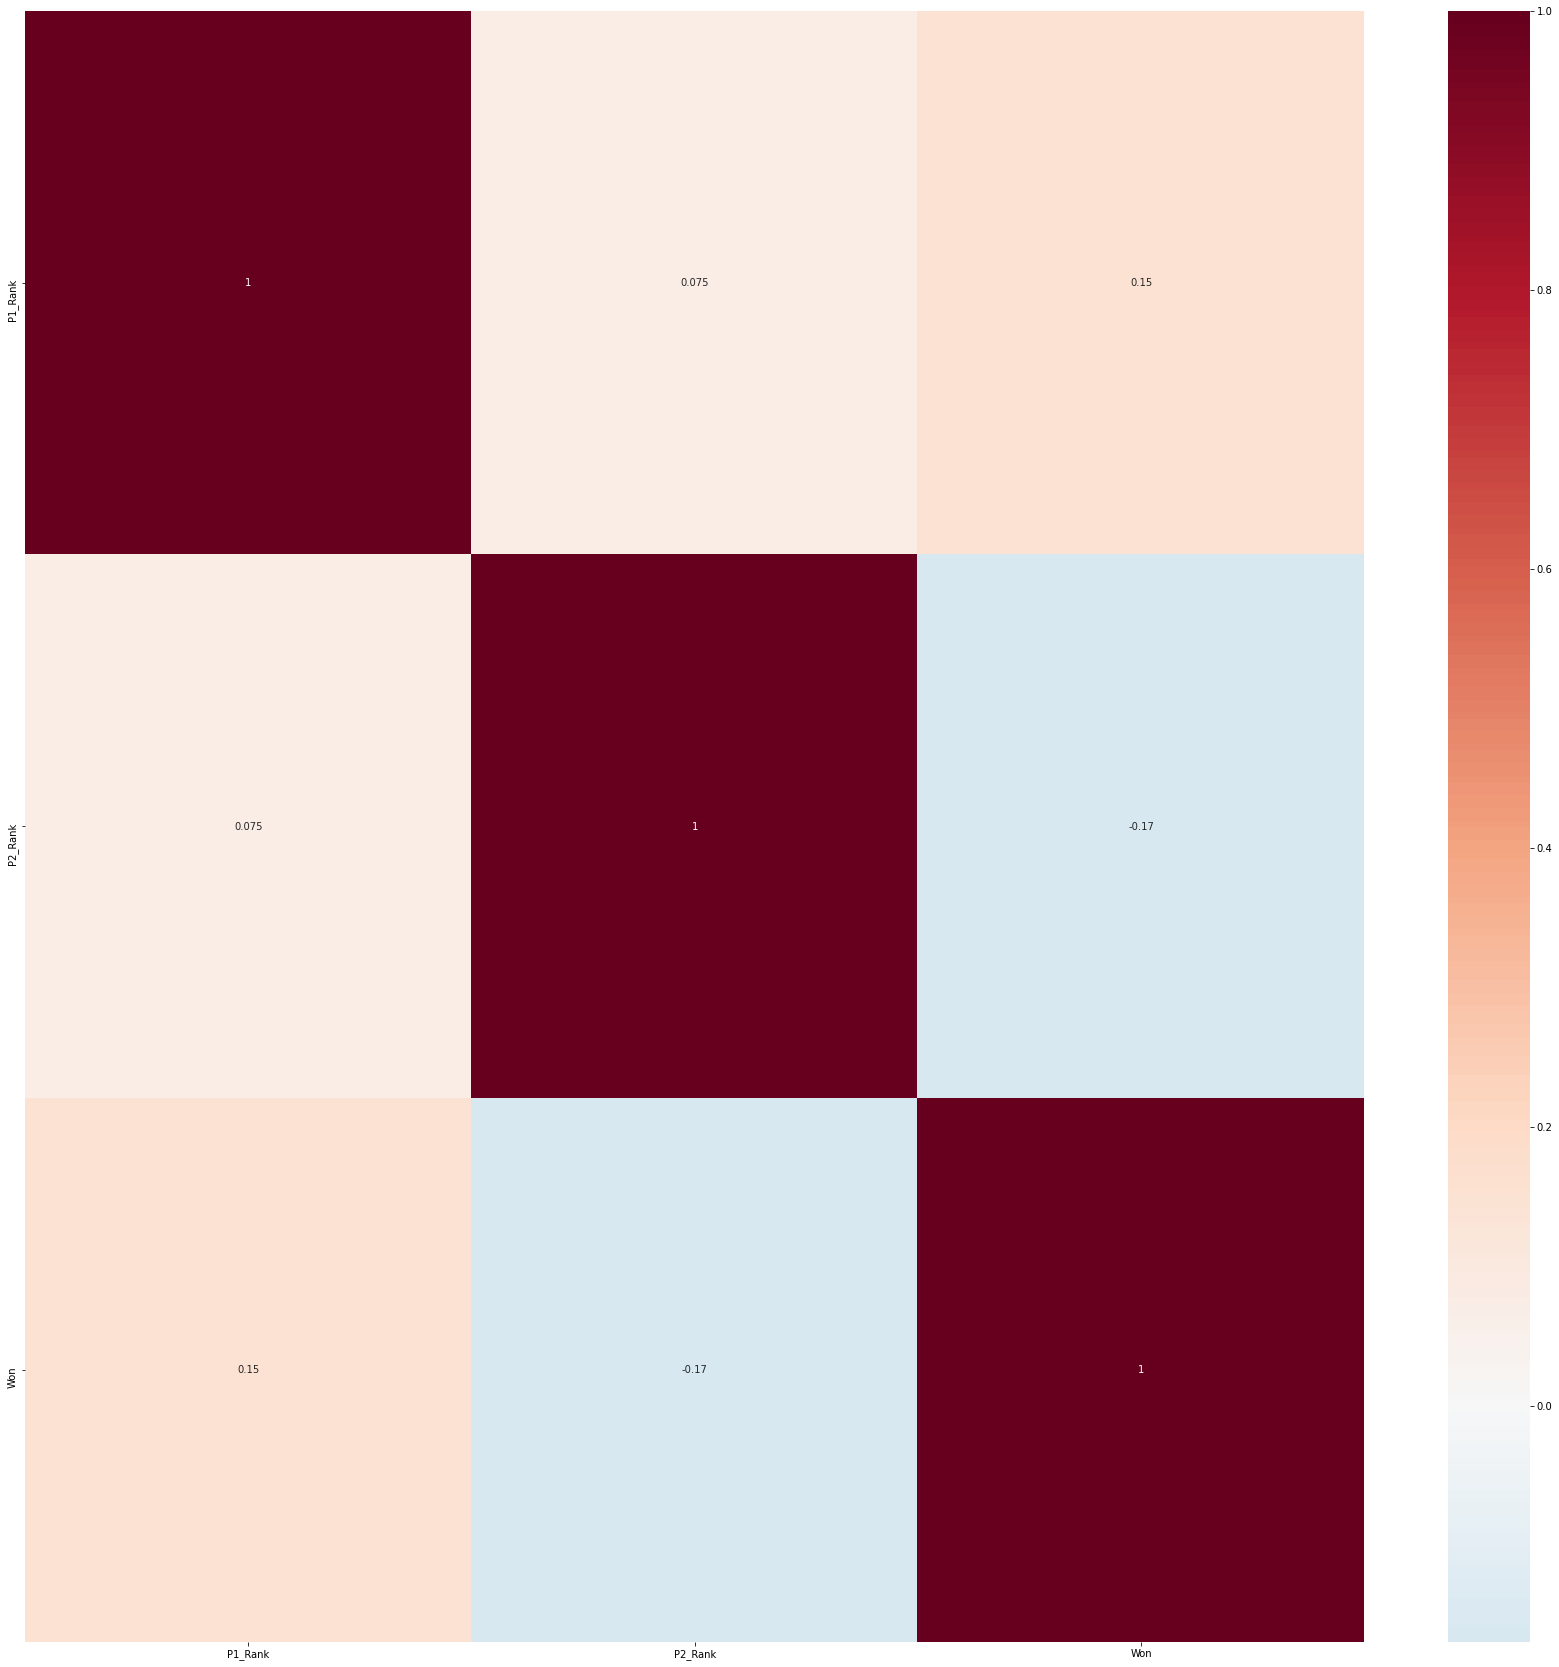

In [41]:
# Heatmap 

plt.figure(figsize=(30,30))
correlation = data.corr()
sns.heatmap(correlation,  annot=True, cmap="RdBu_r", center =0);
plt.show()

#### Data Split and normalization

In [42]:
# Split data and target 

DATA = data.drop('Won',axis=1)
TARGET = data['Won']

In [43]:
# Split train/test

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

In [44]:
# Dataset balancing

#from imblearn.over_sampling import RandomOverSampler 

#ros = RandomOverSampler(random_state=42)

#X_train, y_train = ros.fit_resample(X_train, y_train)

In [45]:
# Normalization

#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(random_state=0)
scaler=qt.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
#from sklearn import preprocessing

#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

## **Model Selection**

In [47]:
from sklearn import linear_model

# Model training

clf=linear_model.LogisticRegression(random_state=10)
clf.fit(X_train_scaled,y_train)

# Model assessment

y_pred = clf.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',clf.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))


Classe prédite     1     2
Classe réelle             
1               1206   603
2                620  1150

Score: 0.6582844369935736

               precision    recall  f1-score   support

           1       0.66      0.67      0.66      1809
           2       0.66      0.65      0.65      1770

    accuracy                           0.66      3579
   macro avg       0.66      0.66      0.66      3579
weighted avg       0.66      0.66      0.66      3579



In [48]:
probs = clf.predict_proba(X_test)

y_preds = np.where(probs[:,1]>0.6,2,1)


cm = pd.crosstab(y_test, y_preds, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm



Classe prédite,1,2
Classe réelle,,
1,1486,323
2,999,771


In [49]:
#PAS SUR 

from sklearn.metrics import roc_curve, auc
fpr, tpr, seuils = roc_curve(y_test, probs[:,1], pos_label=1)

roc_auc = auc(tpr, fpr)


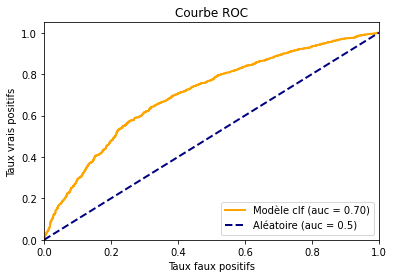

In [50]:
import matplotlib.pylab as plt

plt.plot(tpr, fpr, color='orange',
         lw=2, label='Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux faux positifs')
plt.ylabel('Taux vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Prediction of a new instance

Xnew = [[43,130],[67,107],[50,67],[107,103],[65,107],[3,50],[36,113],[3,192],[21,65]]
                                                    
Xnew = scaler.transform(Xnew)

# make a prediction

ypred = clf.predict(Xnew)

print("Prediction:",ypred)

ynew_prob = clf.predict_proba(Xnew)

print("Predicted=%s" % (ynew_prob))

Prediction: [1 1 1 1 1 1 1 1 1]
Predicted=[[0.72110098 0.27889902]
 [0.61016984 0.38983016]
 [0.56844884 0.43155116]
 [0.50000844 0.49999156]
 [0.6166277  0.3833723 ]
 [0.71290961 0.28709039]
 [0.72926876 0.27073124]
 [0.86623085 0.13376915]
 [0.68669471 0.31330529]]


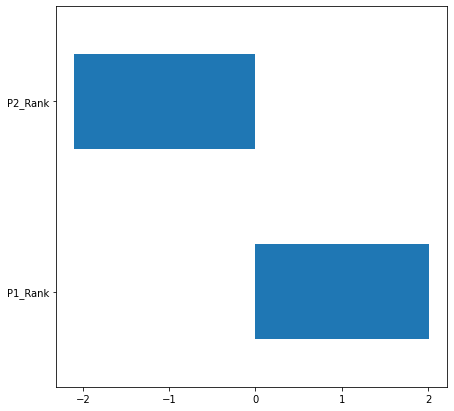

In [52]:
# Weights

plt.figure(figsize=(7,7))

pd.Series(clf.coef_[0], X_train.columns).sort_values(ascending=False).plot(kind='barh');

In [53]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train_scaled, y_train) 
y_pred = clf.predict(X_test) 
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite     1     2
Classe réelle             
1               1233   576
2                648  1122

Score: 0.6580050293378038

               precision    recall  f1-score   support

           1       0.66      0.68      0.67      1809
           2       0.66      0.63      0.65      1770

    accuracy                           0.66      3579
   macro avg       0.66      0.66      0.66      3579
weighted avg       0.66      0.66      0.66      3579



In [54]:
from sklearn import ensemble

clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite     1     2
Classe réelle             
1               1134   675
2                679  1091

Score: 0.621682034087734

               precision    recall  f1-score   support

           1       0.63      0.63      0.63      1809
           2       0.62      0.62      0.62      1770

    accuracy                           0.62      3579
   macro avg       0.62      0.62      0.62      3579
weighted avg       0.62      0.62      0.62      3579



In [55]:

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy",max_depth=3,random_state=123)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite     1     2
Classe réelle             
1               1141   668
2                651  1119

Score: 0.6314613020396759

               precision    recall  f1-score   support

           1       0.64      0.63      0.63      1809
           2       0.63      0.63      0.63      1770

    accuracy                           0.63      3579
   macro avg       0.63      0.63      0.63      3579
weighted avg       0.63      0.63      0.63      3579



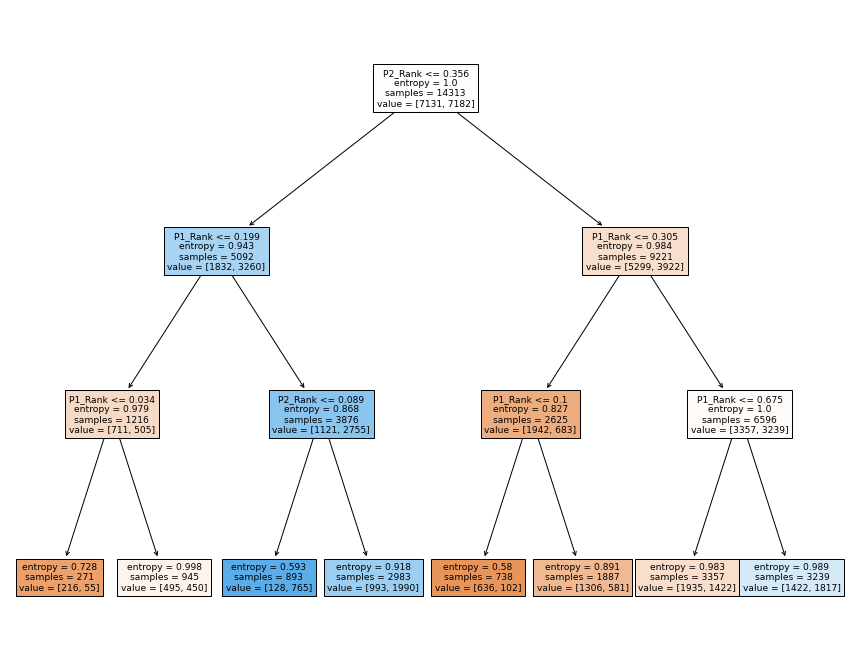

In [56]:
# Features importance

from sklearn.tree import plot_tree

plt.figure(figsize=(15,12))
plot_tree(clf, feature_names = X_train.columns.tolist(), filled=True); #proportion=True

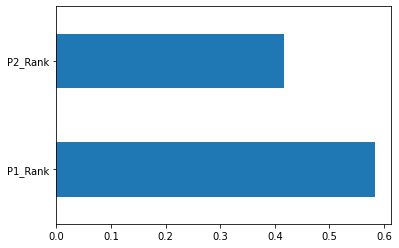

In [57]:
# 3 main features

feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(3).plot(kind = 'barh');

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Model training

clf = LinearDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite     1     2
Classe réelle             
1               1205   604
2                621  1149

Score: 0.6577256216820341

               precision    recall  f1-score   support

           1       0.66      0.67      0.66      1809
           2       0.66      0.65      0.65      1770

    accuracy                           0.66      3579
   macro avg       0.66      0.66      0.66      3579
weighted avg       0.66      0.66      0.66      3579



In [59]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite     1     2
Classe réelle             
1               1221   588
2                627  1143

Score: 0.6605196982397318

               precision    recall  f1-score   support

           1       0.66      0.67      0.67      1809
           2       0.66      0.65      0.65      1770

    accuracy                           0.66      3579
   macro avg       0.66      0.66      0.66      3579
weighted avg       0.66      0.66      0.66      3579



In [60]:
from lightgbm.sklearn import LGBMClassifier

clf = LGBMClassifier()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

Classe prédite     1     2
Classe réelle             
1               1185   624
2                658  1112

Score: 0.6417993853031573

               precision    recall  f1-score   support

           1       0.64      0.66      0.65      1809
           2       0.64      0.63      0.63      1770

    accuracy                           0.64      3579
   macro avg       0.64      0.64      0.64      3579
weighted avg       0.64      0.64      0.64      3579



# **TESTS / WORK IN PROGRESS** 

## ARTHUR

Regression logistique

In [61]:
#from sklearn import linear_model
#df_RL=data_M
#df_RL=df_RL.drop('index', axis=1)
#df_RL=df_RL.drop('Date', axis=1)
#df_RL=df_RL.drop('P1', axis=1)
#df_RL=df_RL.drop('P2', axis=1)
#df_RL.Won=df_RL['Won'].apply(lambda x: 0 if x ==1 else 1)

#DATA = df_RL.drop('Won',axis=1)
#TARGET = df_RL['Won']

#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2)


#clf = linear_model.LogisticRegression(C = 1.0)
#clf.fit(X_train, y_train)

In [62]:
#y_pred = clf.predict(X_test)

# Calcul de la matrice de confusion 

## Méthode 1 : à l'aide de sklearn

#from sklearn.metrics import confusion_matrix 

#cm = confusion_matrix(y_test,y_pred)
#print(cm)

In [63]:
#probs = clf.predict_proba(X_test)
#probs

In [64]:
#url1 = 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/Match.csv'
#match = pd.read_csv(url1)
#url2 = 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/Player.csv'
#player = pd.read_csv(url2)
#url3 = 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/Stats.csv'
#stats = pd.read_csv(url3)

In [65]:
#match.head()

In [66]:
#player.head()

In [67]:
#player.info()

In [68]:
#stats.head()
probs[:,1]

array([0.37634192, 0.30291459, 0.50039732, ..., 0.45752693, 0.62333461,
       0.67248012])

In [69]:
#Calcul du ROI 
#On rattache les prédicitons

y_pred.shape
data_ROI=data.iloc[-3075:,:]
data_ROI.head()

,P1_Rank,P2_Rank,Won
14817,6.0,13.0,1
14818,4.0,6.0,1
14819,20.0,111.0,1
14820,56.0,36.0,2
14821,51.0,152.0,2


In [70]:
#On ajoute les poids de la RL
data_ROI['Prediction']=y_pred.tolist()
data_ROI['Proba_1']=probs[:,1].tolist()
data_ROI['Proba_2']=probs[:,0].tolist()
data_ROI.head(5)

ROI=data_ROI[max(data_ROI.Proba_1,data_ROI.Proba_2) > 0.9]
ROI.head()

ValueError: ignored

In [ ]:
# Création de la variable Succès
data_ROI['Success']=data_ROI['Prediction']

for k in range(data_ROI.shape[0]):
  if data_ROI.iloc[k,38]==data_ROI.iloc[k,39]:
    data_ROI.iloc[k,42]=1
  else:
    data_ROI.iloc[k,42]=0

data_ROI.head(5)

In [ ]:
#Création des variables de gain 365 et Pinacles
data_ROI["gain_Pin"]=1

for k in range(data_ROI.shape[0]):
  if data_ROI.iloc[k,38]==1:
    data_ROI.iloc[k,43]=data_ROI.iloc[k,18]*data_ROI.iloc[k,42]
  else:
    data_ROI.iloc[k,43]=data_ROI.iloc[k,19]*data_ROI.iloc[k,42]


data_ROI["gain_Pin"]=data_ROI["gain_Pin"].apply(lambda x: -1 if x ==0 else x)

data_ROI["gain_365"]=1

for k in range(data_ROI.shape[0]):
  if data_ROI.iloc[k,38]==1:
    data_ROI.iloc[k,44]=data_ROI.iloc[k,20]*data_ROI.iloc[k,42]
  else:
    data_ROI.iloc[k,44]=data_ROI.iloc[k,21]*data_ROI.iloc[k,42]


data_ROI["gain_365"]=data_ROI["gain_365"].apply(lambda x: -1 if x ==0 else x)

In [ ]:
data_ROI.head(5)



In [ ]:
#Créer le graph en filtrant sur les Probas
#Nouvelle colonne max prob et tracer vecteur gain

gain=0
vecteur_gain=()

for i in range(0,1,0.1):
  ROI=data_ROI[max(data_ROI.Proba_1,data_ROI.Proba_2) > i]
  for k in range(ROI.shape[0]):
    gain+=ROI.iloc[k,43]
  vecteur_gain.append(gain)
  gain=0

vecteur_gain

## GUILLAUME

**LOGISTIC REGRESSION OPTIMIZATION**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

scaler = preprocessing.StandardScaler()  # Normalization
selector = SelectKBest()   # Best features selection
lr = LogisticRegression()               

pipe = Pipeline([ ('scaling', scaler), 
                 ('selection', selector),      
                 ('model', lr)])           

param_grid = {
    'selection__k' : [1, 2, 3, 4, 5, 'all'],  
    'model__solver' : ['lbfgs', 'liblinear'], 
    'model__C': [10**(i) for i in range(-4,3)]    
}

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

grid.fit(X_train,y_train)  

print(grid.best_params_) # Best parameters
print(grid.best_score_) # Best cross validation score

# Model assessment

y_pred = grid.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',grid.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))
      





In [ ]:
#Arthur Courbe ROC



**SVC OPTIMIZATION**

In [ ]:
#X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

#scaler = QuantileTransformer()  # Normalization
#SVM = svm.SVC()             

#pipe = Pipeline([ ('scaling', scaler),    
                 #('model', SVM)])           

#param_grid = {
    #'model__kernel' : ['rbf', 'linear'], 
    #'model__C': [10**(i) for i in range(-4,3)]   
#}

#grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

#grid.fit(X_train,y_train)  

#print(grid.best_params_) # Best parameters
#print(grid.best_score_) # Best cross validation score

# Model assessment

#y_pred = grid.predict(X_test)

# Confusion Matrix 

#cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
#print(cm)

# Score

#print('\n''Score:',grid.score(X_test, y_test))

#Classification report

#print('\n',classification_report(y_test, y_pred))

**LINEAR DISCRIMINANT ANALYSIS OPTIMISATION**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

#scaler = StandardScaler()
scaler = QuantileTransformer()  # Normalization
selector = SelectKBest()   # Best features selection
ld = LinearDiscriminantAnalysis()            

pipe = Pipeline([ ('scaling', scaler), 
                 ('selection', selector),      
                 ('model', ld)])           

param_grid = {
    'selection__k' : [4, 5, 'all'],  
    'model__solver' : ['svd', 'lsqr', 'eigen']   
}

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

grid.fit(X_train,y_train)  

print(grid.best_params_) # Best parameters
print(grid.best_score_) # Best cross validation score

# Model assessment

y_pred = grid.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',grid.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))

**LGBM OPTIMZATION**

In [ ]:
#!pip install optuna

In [ ]:
#import optuna

#def objective(trial):

  #X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

  #scaler = QuantileTransformer()  # Normalization
  #selector = SelectKBest()   # Best features selection
  #lgbm = LGBMClassifier()           

  #pipe = Pipeline([ ('scaling', scaler), 
                 #('selection', selector),      
                 #('model', lgbm)])           

  #param_grid = {
    #'selection__k' : [4, 5, 'all'],  
    #'model__max_depth' : trial.suggest_int("model__max_depth",2, 6),   
    #'model__learning_rate' : trial.suggest_loguniform("model__learning_rate", 1e-4, 10),
    #'model__n_estimators' : trial.suggest_int("n_estimators", 1, 400),
    #'model__min_split_gain' : trial.suggest_uniform("min_split_gain", 0, 1),
    #'model__device' : 'gpu'
  #}

  #grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

  #grid.fit(X_train,y_train)  

  #print(grid.best_params_) # Best parameters
  #print(grid.best_score_) # Best cross validation score

  #return grid.best_score_

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)  # Specify the number of trials.

# Model assessment

#y_pred = grid.predict(X_test)

# Confusion Matrix 

#cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
#print(cm)

# Score

#print('\n''Score:',grid.score(X_test, y_test))

#Classification report

#print('\n',classification_report(y_test, y_pred))

In [ ]:

X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

scaler = QuantileTransformer()  # Normalization
selector = SelectKBest()   # Best features selection
lgbm = LGBMClassifier()           

pipe = Pipeline([ ('scaling', scaler),       
                 ('model', lgbm)])           

param_grid = { 
    'model__max_depth' : [19],   
    'model__learning_rate' : [0.295],
    'model__gamma':[0.8],
    'model__lambda':[0],
    'model__alpha':[2],
    'model__num_rounds':[300],
    'model__early_stop':[5],
  }

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

grid.fit(X_train,y_train)  

print(grid.best_params_) # Best parameters
print(grid.best_score_) # Best cross validation score

# Model assessment

y_pred = grid.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',grid.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))

In [ ]:

#n_col = len(data_M.columns) 

#fig, axs = plt.subplots(nrows = n_col)

#for variable, ax in zip(data_M.columns, axs):
    #sns.violinplot(x = 'Won', y = variable, data = data_M, ax = ax)
    #ax.set_title(variable)
    
    
#fig.set_size_inches(16, 300)

In [ ]:

# TO TEST - creation of dataframe columns in a cleaner way

#---------------------
#def some_func(x):
 # a = 1
  #b = 2
  #return a,b 

#df[['column1','column2']] = df.apply(some_func,axis=1, result_type ='expand')
#---------------------

In [ ]:



# EXPERIMENTS 2 # Grouping by classes

# Let's try divide the ATP rankings into 4 categories

#data['P1_Rank_classes']=pd.qcut(data['P1_Rank'],labels=[1,2,3,4],q=4)
#data['P2_Rank_classes']=pd.qcut(data['P2_Rank'],labels=[1,2,3,4],q=4)
#data["P1_Rank_classes"] = data["P1_Rank_classes"].astype('category')
#data["P1_Rank_classes"] = data["P1_Rank_classes"].cat.codes
#data["P2_Rank_classes"] = data["P2_Rank_classes"].astype('category')
#data["P2_Rank_classes"] = data["P2_Rank_classes"].cat.codes
#data.drop('P1_Rank',axis=1,inplace=True)
#data.drop('P2_Rank',axis=1,inplace=True)
#charges_classes = pd.qcut(df.total_charges, labels=[1,2,3,4,5,6,7,8]q=8)

# EXPERIMENTS 3 # Keep most frequent players in the dataset.

# Get those players

#most_frequent_P1 = data['P1'].value_counts()[:300].index.tolist()
#most_frequent_P2 = data['P2'].value_counts()[:300].index.tolist()

# Dataframe is filtered to only take the most productive players

#data=data[data['P1'].isin(most_frequent_P1)&data['P2'].isin(most_frequent_P2)]


# EXPERIMENT 4 # Create "Month variable"

#data['Month'] = data.Date
#data['Month'] = data.Month.apply(lambda x: x[:-3])
#data['Month'] = pd.to_datetime(data.Month)

In [ ]:
#import xgboost as xgb -> lgbm is preferred 

#X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

# Variable encoding:
#y_train = [0 if x == 1 else 1 for x in y_train]
#y_test = [0 if x == 1 else 1 for x in y_test]

# Training parameters
#params = {'objective': 'binary:logistic', 'max_depth': 6}

# DMatrix preparation
#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest =  xgb.DMatrix(data = X_test, label = y_test)

# Model training
#clf = xgb.train(params, dtrain, 200)

# Model assessment

#probs = clf.predict(dtest)
#preds = [0 if x<0.5 else 1 for x in probs]

#print(classification_report(y_test, preds))

In [ ]:
# Validation croisée imbriquée (Nested CV) 

#from sklearn.model_selection import GridSearchCV, cross_val_score
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC

#clf_lr = LogisticRegression (random_state=22, max_iter=2000)
#clf_rf = RandomForestClassifier (random_state=22)
#clf_svc = SVC (random_state=22)

#param_grid_lr  = {'solver': ['liblinear', 'lbfgs'],
                     #'C': np.logspace(-4,2,9)}

#param_grid_rf  = {'n_estimators': [10, 50, 100, 250, 500, 1000],
                     #'min_samples_leaf': [1, 3, 5],
                     #'max_features': ['sqrt', 'log2']}

#param_grid_svc = {'kernel': ['rbf'],'C': np.logspace(-4, 4, 9),'gamma': np.logspace(-4, 0, 4)},{'kernel': ['linear'],'C': np.logspace(-4, 4, 9)}
                     

#gridcvs = {}

#for pgrid, clf, name in zip((param_grid_lr,
                             #param_grid_rf, param_grid_svc),
                            #(clf_lr, clf_rf, clf_svc),
                            #('LogisticRegression', 'RF', 'SVM')):
    #gcv = GridSearchCV(clf,
                       #pgrid,
                       #cv=3,
                       #refit=True)
    #gridcvs[name] = gcv

#from sklearn.model_selection import StratifiedKFold

#outer_cv = StratifiedKFold(n_splits=3, shuffle=True)
#outer_scores = {}

#for name, gs in gridcvs.items():
    #nested_score = cross_val_score(gs, 
                                   #X_train, 
                                   #y_train, 
                                   #cv=outer_cv)
    #outer_scores[name] = nested_score
    #print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

In [ ]:
#from skater.core.explanations import Interpretation
#from skater.model import InMemoryModel

#interpreter = Interpretation(X_train, feature_names=X_train.columns)

#def predict_xg(x):
   # return pd.DataFrame(clf.predict(xgb.DMatrix(x)))

#model = InMemoryModel(predict_xg, examples = X_train)


#plt.figure(figsize=(20,12))
                  
#plots = interpreter.feature_importance.plot_feature_importance(model, ascending=True);

#interpreter.partial_dependence.plot_partial_dependence(['P1_Elo'], model, grid_resolution=100,
                                                      # with_variance=True, figsize = (6, 4));

#import shap

#explainer = shap.TreeExplainer(clf)
#shap_values = explainer.shap_values(X_test)
#print('Expected Value:', explainer.expected_value)

#pd.DataFrame(shap_values).head()

#shap.summary_plot(shap_values, X_test, plot_type="bar")
#shap.summary_plot(shap_values, X_test)

## WILL